# Дерево решений классификация


#### Описание набора данных:  

age     -  возраст: разница в 5 лет  
height(cm)   -      рост(см)  
weight(kg)  -   вес(кг)  
waist(cm)   -   талия(см) окружность талии длина  
eyesight(left)  -   зрение(слева)  
eyesight(right) -   зрение(справа)  
hearing(left)   -   слух(слева)  
hearing(right)  -   слух(справа)  
systolic    -   систолическое: артериальное давление  
relaxation  -   расслабление: артериальное давление 
fasting blood sugar -   уровень сахара в крови натощак  
Cholesterol     -   холестерин: общие  
triglyceride    -   триглицериды  
HDL     -   ЛПВП: тип холестерина  
LDL     -   ЛПНП: тип холестерина  
hemoglobin  -   гемоглобин  
Urine protein   -   белок  мочи  
serum creatinine    -   сывороточный креатинин  
AST -   АСТ: тип глутаминовой щавелевоуксусной трансаминазы  
ALT -   АЛТ: тип глутаминовой щавелевоуксусной трансаминазы  
Gtp -   ГТП: γ-ГТФ  
dental caries   -   кариес зубов  
smoking -   курение  

In [ ]:
import cudf
import cuml
print("cuDF и cuML импортированы успешно!")

import cupy as cp
try:
    x = cp.array([1, 2, 3])  # Простой тест на выделение памяти в GPU
    print("CuPy работает на GPU:", x)
except cp.cuda.runtime.CUDARuntimeError as e:
    print("Ошибка CuPy:", e)


import cupy as cp
print(cp.cuda.is_available())

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Используем первый GPU

import cupy as cp
print(cp.cuda.runtime.getDeviceCount()) 

!conda list | grep cuml

cuDF и cuML импортированы успешно!
CuPy работает на GPU: [1 2 3]
True
1
cuml                      25.02.00        cuda12_py312_250213_ga3a131a8b_0    rapidsai
libcuml                   25.02.00        cuda12_250213_ga3a131a8b_0    rapidsai
libcumlprims              25.02.00        cuda12_250213_g5eeba45_0    rapidsai


In [1]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import  f1_score

import cudf
import cuml
from cuml.ensemble import RandomForestClassifier
from cuml.metrics.accuracy import accuracy_score  as cuml_accuracy_score
from cuml.metrics._ranking import roc_auc_score as cuml_roc_auc_score
from cuml.metrics._ranking import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)
print("\nДатасет: ")
!ls dataset


Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/6_Tree_Classification

Датасет: 
test.csv  train.csv


## 1) Загрузка

In [2]:


train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))

X = train_df.drop(columns=['smoking'])
y = train_df['smoking']
print("\nПропуски:")
train_df.isnull().sum()



Размер данных:  (38984, 23)
 age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  smoking
  35         170          85       97.0             0.9              0.9              1               1       118          78                   97          239           153   70  142        19.8              1               1.0   61  115  125              1        1
  20         175         110      110.0             0.7              0.9              1               1       119          79                   88          211           128   71  114        15.9              1               1.1   19   25   30              1        0
  45         155          65       86.0             0.9              0.9              1               1       110          80                   80          193        

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

## 2) Анализ

In [3]:
# 2) EDA: исследование данных
def explore_data(df):
    eda_results = pd.DataFrame({
        'Missing (%)': df.isnull().mean() * 100,
        'Min': df.min(),
        'Max': df.max(),
        'Mean': df.mean(),
        'Median': df.median(),
        'Variance': df.var(),
        'Quantile 0.1': df.quantile(0.1),
        'Quantile 0.9': df.quantile(0.9),
        'Quartile 1': df.quantile(0.25),
        'Quartile 3': df.quantile(0.75),
    })
    return eda_results

print("EDA Анализ\n")
explore_data(train_df)


EDA Анализ



,Missing (%),Min,Max,Mean,Median,Variance,Quantile 0.1,Quantile 0.9,Quartile 1,Quartile 3
age,0.0,20.0,85.0,44.127591,40.0,145.529573,30.0,60.0,40.0,55.0
height(cm),0.0,130.0,190.0,164.689488,165.0,84.410288,150.0,175.0,160.0,170.0
weight(kg),0.0,30.0,135.0,65.938718,65.0,166.321797,50.0,85.0,55.0,75.0
waist(cm),0.0,51.0,129.0,82.062115,82.0,86.989160,70.0,94.0,76.0,88.0
eyesight(left),0.0,0.1,9.9,1.014955,1.0,0.248529,0.6,1.5,0.8,1.2
eyesight(right),0.0,0.1,9.9,1.008768,1.0,0.243851,0.6,1.5,0.8,1.2
hearing(left),0.0,1.0,2.0,1.025369,1.0,0.024726,1.0,1.0,1.0,1.0
hearing(right),0.0,1.0,2.0,1.026190,1.0,0.025505,1.0,1.0,1.0,1.0
systolic,0.0,71.0,233.0,121.475631,120.0,186.145675,104.0,138.0,112.0,130.0
relaxation,0.0,40.0,146.0,75.994408,76.0,93.291147,64.0,88.0,70.0,82.0


In [4]:
# Доля 1 в целевой переменной
target_ratio = train_df['smoking'].mean()
print(f'Доля курящих (smoking=1): {target_ratio:.2%}')

Доля курящих (smoking=1): 36.73%


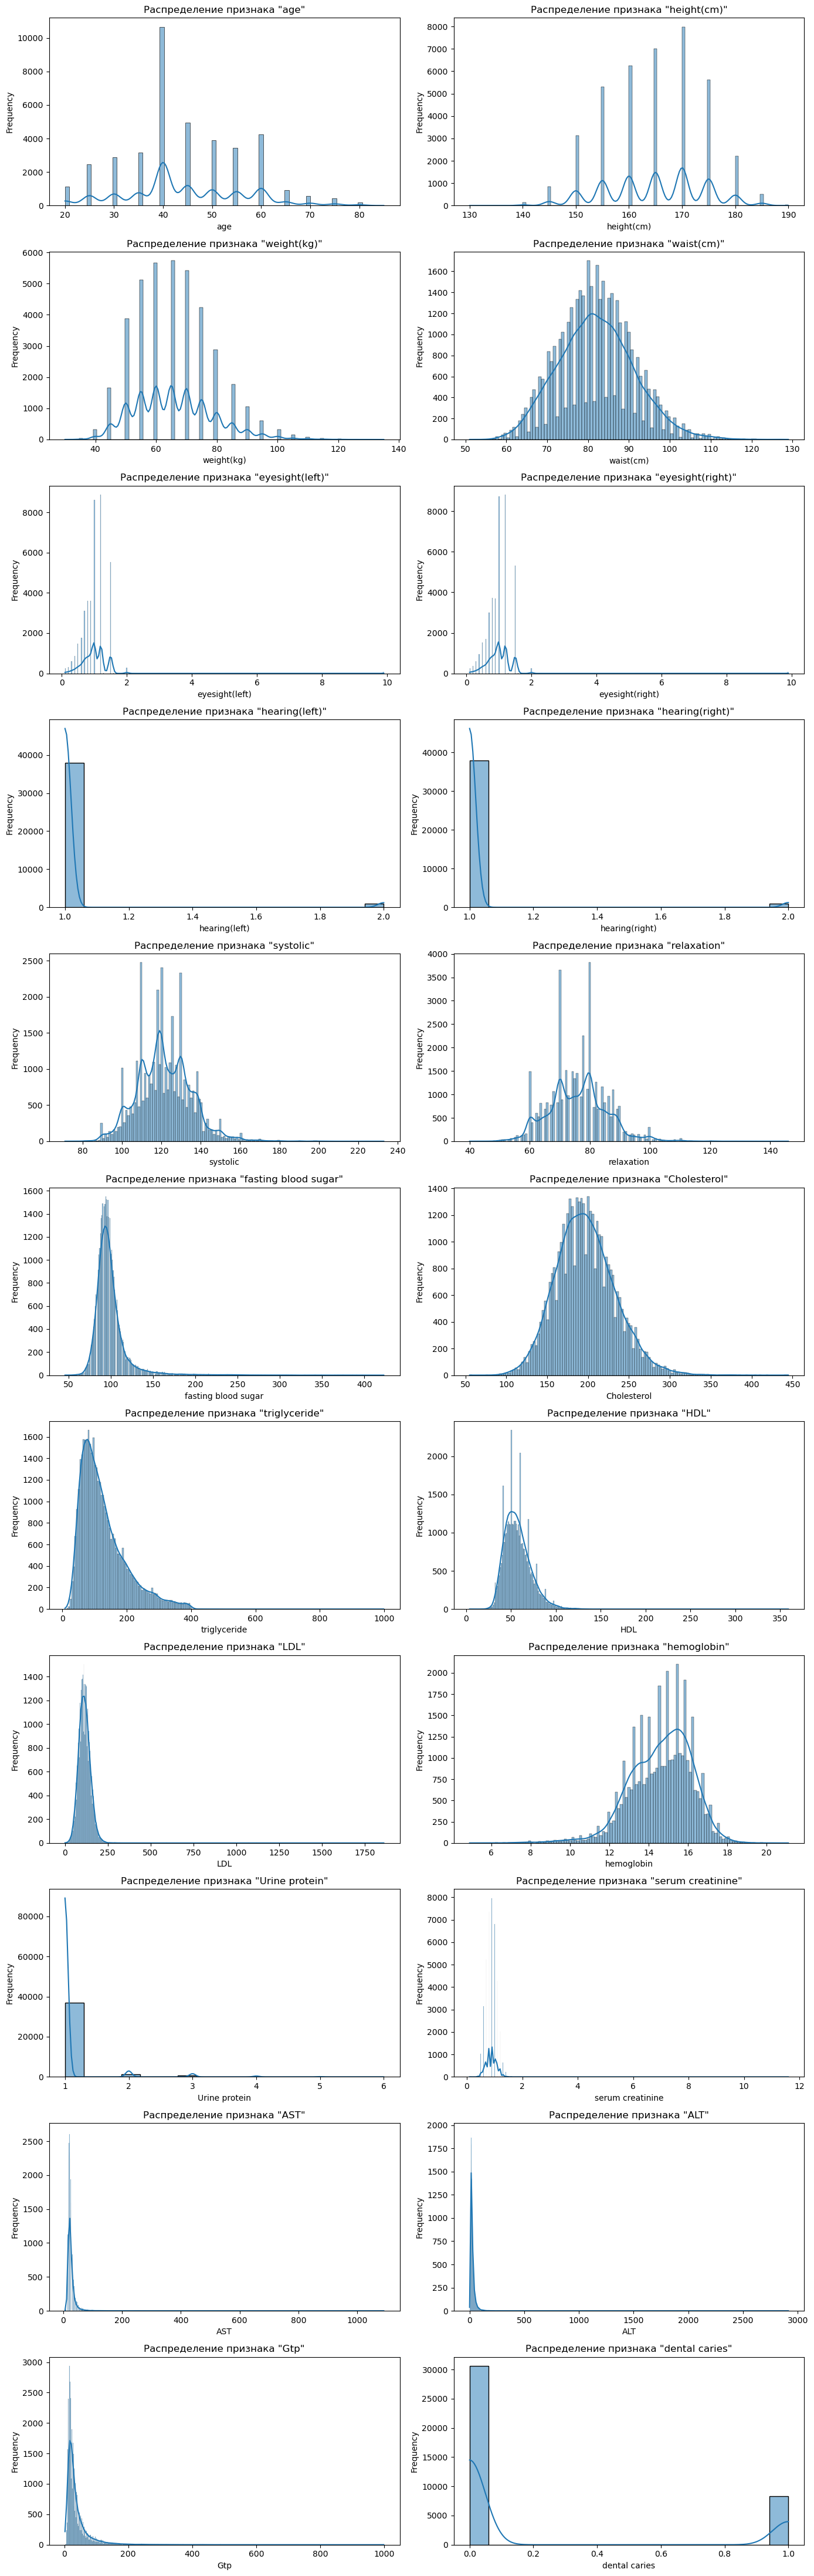

In [5]:
# Получаем список всех признаков (кроме целевой переменной)
features = X.columns

num_features = len(features)
num_rows = (num_features + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
axes = axes.flatten() 

for i, feature in enumerate(features):
    sns.histplot(X[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение признака "{feature}"')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


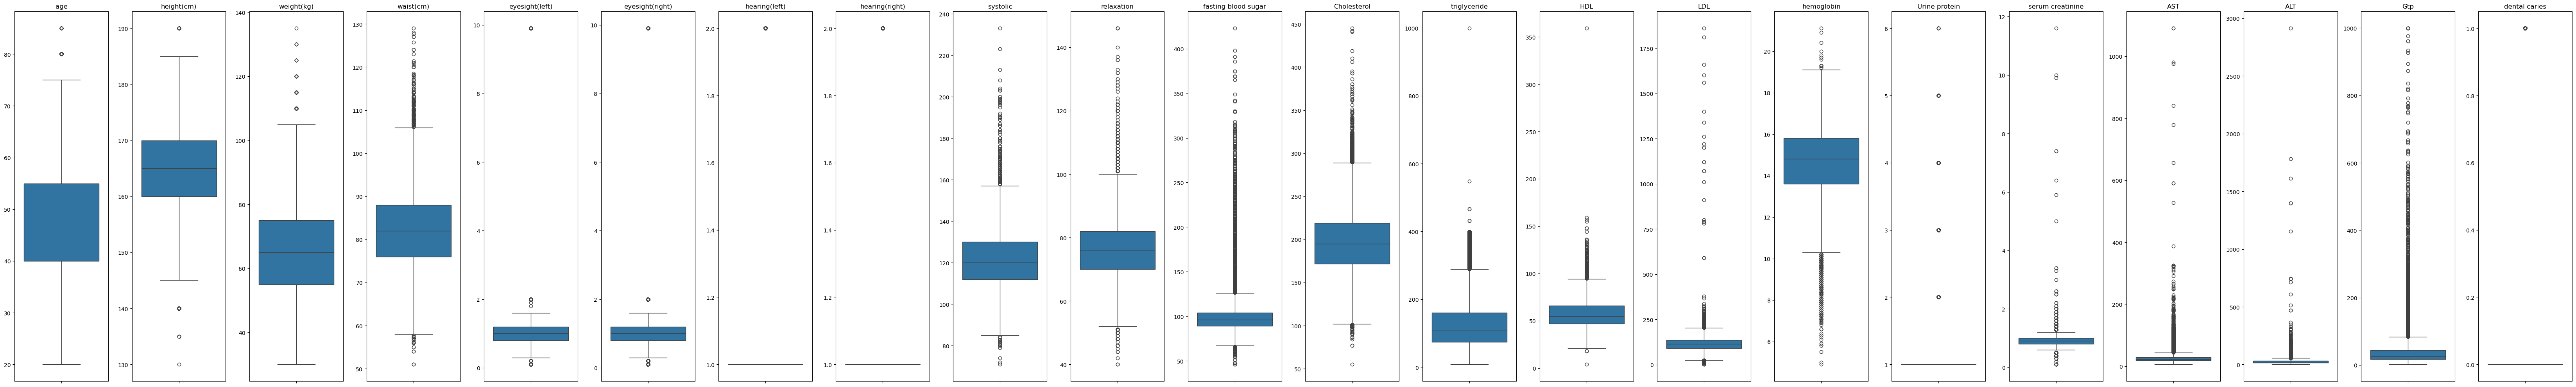

In [6]:
features = X.columns

num_features = len(features)

fig, axes = plt.subplots(1, num_features, figsize=(num_features * 3, 10))

for i, feature in enumerate(features):
    sns.boxplot(y=X[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

## 3) Обучение

In [7]:
!which nvcc
!nvcc --version
import os
print(os.environ.get("CUDA_HOME"))
import cuml
print(cuml.__version__)


/home/maksim/anaconda3/envs/rapids-25.02/bin/nvcc
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:20:09_PST_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0
None
25.02.00


In [8]:
import cudf
import cuml
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.metrics.accuracy import accuracy_score  as cuml_accuracy_score
from cuml.metrics._ranking import roc_auc_score as cuml_roc_auc_score
from cuml.metrics._ranking import precision_recall_curve


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

# Преобразуем в GPU-совместимый формат cudf
X_cudf = cudf.DataFrame(X)
y_cudf = cudf.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)

/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


In [9]:
 #RandomForestClassifier?

In [10]:
cuRFC(n_estimators=1, max_features='sqrt', max_depth=10)

RandomForestClassifier()

/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Лучшее значение Precision: 0.5459
Лучшее значение Recall: 0.8317
=== Метрики классификации ===
Accuracy: 0.7118
ROC AUC: 0.6834

=== Confusion Matrix ===


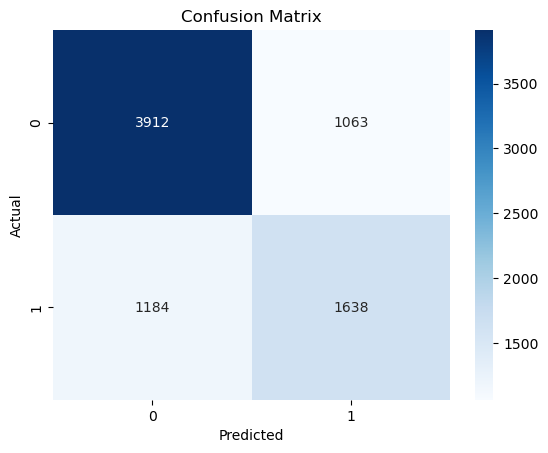

In [11]:

model = cuRFC(
    n_estimators=1,           # Используем одно дерево
    max_depth=10,             # Глубина дерева
    max_features='sqrt',      # Количество признаков (или столбцов), которые будут использованы при разделении узлов дерева
    min_samples_split=4,      # Минимальное количество выборок для разбиения узла
    min_samples_leaf=2,       # Минимальное количество выборок в листе
    split_criterion='gini'          # Критерий разбиения ('gini' или 'entropy')
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)


acc = cuml_accuracy_score(y_test, y_pred)


y_pred_proba = model.predict_proba(X_test) 
y_pred_proba = y_pred_proba.to_numpy()[:, 1]  


prec, rec, thresholds = precision_recall_curve(y_test.to_numpy(), y_pred_proba)  
 
# f1 = f1_score(y_test, y_pred)
roc_auc = cuml_roc_auc_score(y_test, y_pred)


conf_matrix = confusion_matrix(y_test.to_pandas(), y_pred.to_pandas())


f1_scores = 2 * (prec * rec) / (prec + rec)
best_index = f1_scores.argmax()  

best_prec = prec[best_index]
best_rec = rec[best_index]

print(f"Лучшее значение Precision: {best_prec:.4f}")
print(f"Лучшее значение Recall: {best_rec:.4f}")


print("=== Метрики классификации ===")
print(f"Accuracy: {acc:.4f}")

print(f"ROC AUC: {roc_auc:.4f}")

print("\n=== Confusion Matrix ===")

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Подбор гиперпараметров

In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')  
y_test = y_test.astype('float32')  


param_grid = {
    "n_estimators": [1],          # Количество деревьев
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],              # Максимальная глубина
    "max_features": ['sqrt', 'log2'],    # Количество признаков
    "min_samples_split": [2, 4, 6],         # Мин. выборок для разбиения узла
    "min_samples_leaf": [1, 2, 3],          # Мин. выборок в листе
    "split_criterion": ['gini', 'entropy']  # Критерий разбиения
}

best_f1 = 0
best_model = None
best_params = None

for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for max_features in param_grid["max_features"]:
            for min_samples_split in param_grid["min_samples_split"]:
                for min_samples_leaf in param_grid["min_samples_leaf"]:
                    for split_criterion in param_grid["split_criterion"]:
                        
                        model = cuRFC(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            max_features=max_features,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            split_criterion=split_criterion
                        )
                        model.fit(X_train, y_train)

                        y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]

                        prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
                        f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)  
                        best_idx = f1_scores.to_numpy().argmax()

                        if f1_scores[best_idx] > best_f1:
                            best_f1 = f1_scores[best_idx]
                            best_model = model
                            best_params = {
                                "n_estimators": n_estimators,
                                "max_depth": max_depth,
                                "max_features": max_features,
                                "min_samples_split": min_samples_split,
                                "min_samples_leaf": min_samples_leaf,
                                "split_criterion": split_criterion
                            }

# Вывод лучших параметров
print("Лучшие параметры:", best_params)
print("Лучший F1-score:", best_f1)


Лучшие параметры: {'n_estimators': 1, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 3, 'split_criterion': 'entropy'}
Лучший F1-score: 0.666666640975611


=== Метрики классификации ===
Accuracy: 0.7149
Лучшее значение Precision: 0.5501
Лучшее значение Recall: 0.8459
F1-score: 0.6090
ROC AUC: 0.6929

=== Confusion Matrix ===
[[3843 1132]
 [1091 1731]]


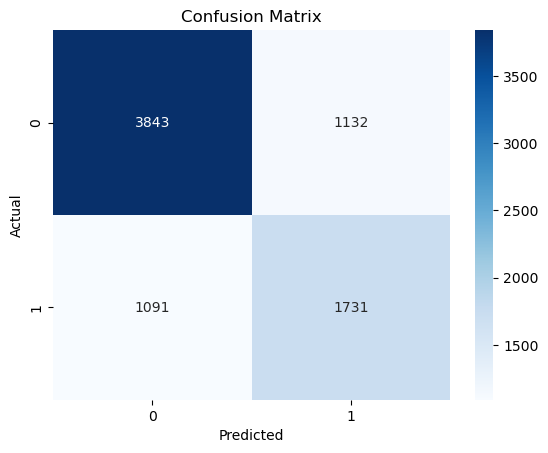

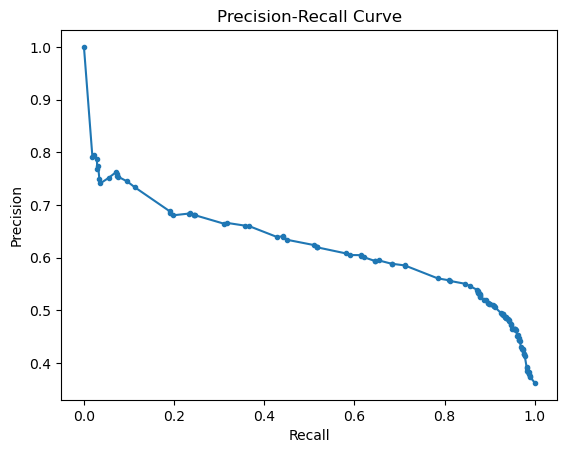

In [14]:
model = cuRFC(
    n_estimators=1,                     # Используем одно дерево
    max_depth=8,                        # Глубина дерева
    max_features='sqrt',                # Количество признаков (или столбцов), которые будут использованы при разделении узлов дерева
    min_samples_split=2,                # Минимальное количество выборок для разбиения узла
    min_samples_leaf=3,                 # Минимальное количество выборок в листе
    split_criterion='entropy'           # Критерий разбиения ('gini' или 'entropy')
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = cuml_accuracy_score(y_test, y_pred)

y_pred_proba = model.predict_proba(X_test)  
y_pred_proba = y_pred_proba.to_numpy()[:, 1]  

prec, rec, thresholds = precision_recall_curve(y_test.to_numpy(), y_pred_proba)  

 
f1 = f1_score(y_test.to_numpy(), y_pred.to_numpy())
roc_auc = cuml_roc_auc_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test.to_pandas(), y_pred.to_pandas())

f1_scores = 2 * (prec * rec) / (prec + rec+ 1e-9)
best_index = f1_scores.argmax() 

best_prec = prec[best_index]
best_rec = rec[best_index]

print("=== Метрики классификации ===")

print(f"Accuracy: {acc:.4f}")

print(f"Лучшее значение Precision: {best_prec:.4f}")
print(f"Лучшее значение Recall: {best_rec:.4f}")

print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\n=== Confusion Matrix ===")
print(conf_matrix)


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

import matplotlib.pyplot as plt

plt.plot(rec, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## 4) Визуализация дерева

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

print('\nРазмер данных: ', train_df.shape)

X = train_df.drop(columns=['smoking'])
y = train_df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Размер данных:  (38984, 23)


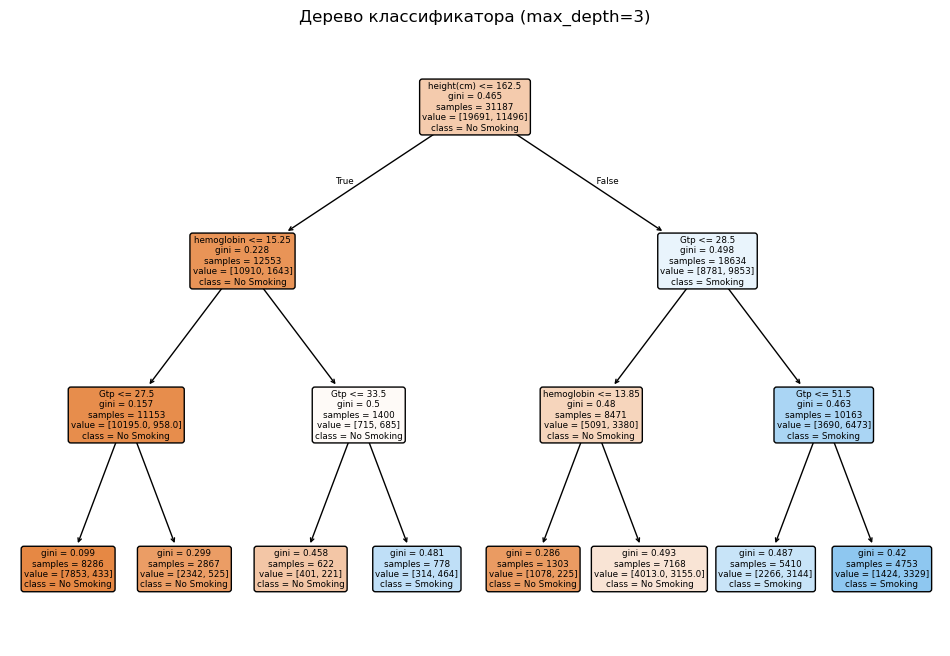

In [16]:

clf = DecisionTreeClassifier(max_depth=3, random_state=42) 
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['No Smoking', 'Smoking'], rounded=True)
plt.title("Дерево классификатора (max_depth=3)")
plt.show()


## 5) Выбор столбца


Размер данных:  (38984, 23)
Столбец с наибольшим весом: Feature       height(cm)
Importance      0.651431
Name: 1, dtype: object


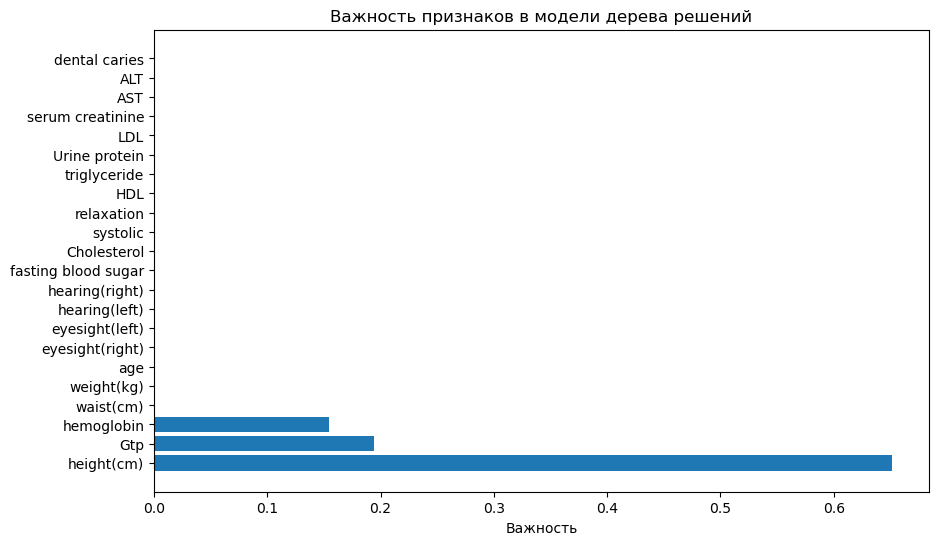

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

print('\nРазмер данных: ', train_df.shape)

X = train_df.drop(columns=['smoking'])
y = train_df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)  
clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Столбец с наибольшим весом:", importance_df.iloc[0])

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Важность')
plt.title('Важность признаков в модели дерева решений')
plt.show()


## 6) модель дерева решений с одним столбцом

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd


train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

X = train_df[['height(cm)']]  
y = train_df['smoking']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6712838271129922


## 7)

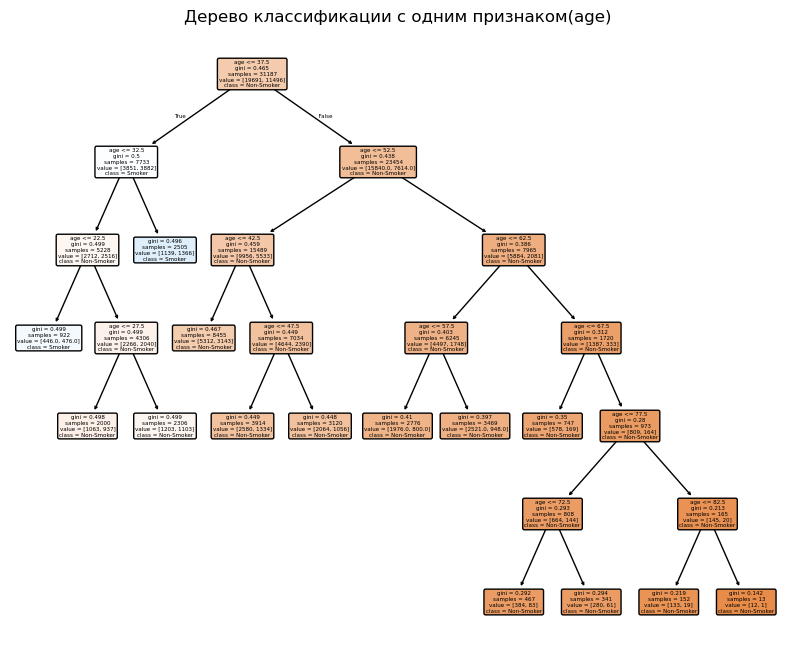

<Figure size 640x480 with 0 Axes>

In [20]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

X = train_df[['age']]  
y = train_df['smoking'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

plt.figure(figsize=(10, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Non-Smoker', 'Smoker'], rounded=True)
plt.title('Дерево классификации с одним признаком(age)')
plt.show()

plt.savefig('decision_tree.png')


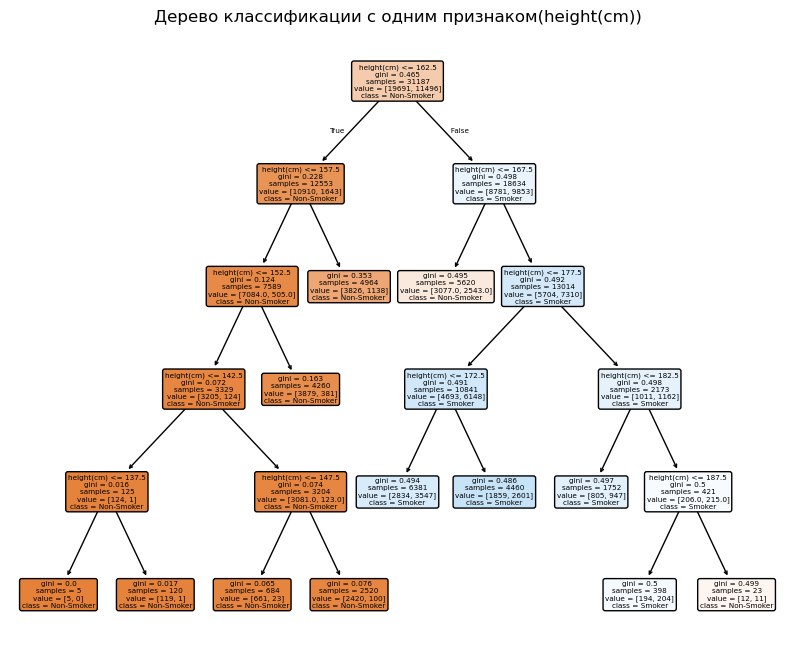

<Figure size 640x480 with 0 Axes>

In [21]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

X = train_df[['height(cm)']]  
y = train_df['smoking'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

plt.figure(figsize=(10, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Non-Smoker', 'Smoker'], rounded=True)
plt.title('Дерево классификации с одним признаком(height(cm))')
plt.show()

plt.savefig('decision_tree.png')
